# Capstone Notebook

# Stakeholder and Business Problem

This project is intended to provide the Minnesota Department of Transportation (MNDOT) with information and recommendations about what factors lead to heavy traffic volume and if anything can be done along I-94 to mitigate these factors. The dataset was pulled from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#).

In [45]:
# Import tools and libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)

# try:
    # %load_ext autotime
# except:
    # !pip install ipython-autotime
    # %load_ext autotime
    
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2023-04-09 13:06:48 -06:00)


In [46]:
# Read in traffic data
df = pd.read_csv('data\Metro_Interstate_Traffic_Volume.csv')
df_noaa = pd.read_csv('data/noaa_data.csv')

time: 78 ms (started: 2023-04-09 13:06:48 -06:00)


In [47]:
# Previewing data
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


time: 16 ms (started: 2023-04-09 13:06:48 -06:00)


Per the UCI website that hosts the data, the feature descriptions are as follows:

holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair<br>
temp: Numeric Average temp in kelvin<br>
rain_1h: Numeric Amount in mm of rain that occurred in the hour<br>
snow_1h: Numeric Amount in mm of snow that occurred in the hour<br>
clouds_all: Numeric Percentage of cloud cover<br>
weather_main: Categorical Short textual description of the current weather<br>
weather_description: Categorical Longer textual description of the current weather<br>
date_time: DateTime Hour of the data collected in local CST time<br>
traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume<br>

# EDA

Let's take a look at the first variable in our dataset, *temp*.

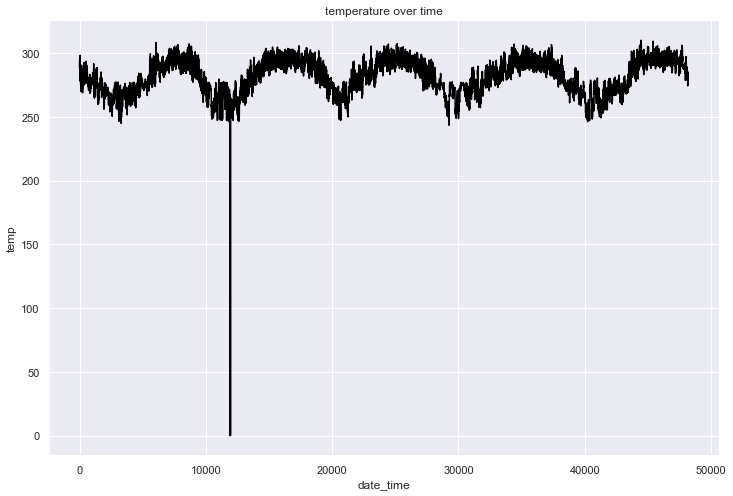

time: 219 ms (started: 2023-04-09 13:06:48 -06:00)


In [48]:
# Plotting temperature over time for entire dataset
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black")

ax.set_xlabel('date_time');
ax.set_ylabel('temp')
ax.set_title('temperature over time');

It appears that the temperature follows an expected seasonal pattern except for a smattering of values that are listed as zero. Let's explore where those values are.

In [49]:
# Viewing zero values for the 'temp' column
df[df['temp'] == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


time: 16 ms (started: 2023-04-09 13:06:48 -06:00)


There are two days in early 2014 that have a few hours with the temperature listed at zero. We know that the 'temp' column is listed in units of Kelvin; zero degrees Kelvin is the lowest limit of the thermodynamic temperature scale where atoms/particles stop moving so it is safe to assume this data is not accurate.

To fix this, we'll take a look at the recorded temperatures immediately before and after the inaccurate temperature data and fill them in with the average value.

In [50]:
# Viewing temperature values immediately before and after the inaccurate data
df['temp'].loc[11897:11902], df['temp'].loc[11945:11952]

(11897    255.93
 11898      0.00
 11899      0.00
 11900      0.00
 11901      0.00
 11902    255.93
 Name: temp, dtype: float64,
 11945    255.37
 11946      0.00
 11947      0.00
 11948      0.00
 11949      0.00
 11950      0.00
 11951      0.00
 11952    255.62
 Name: temp, dtype: float64)

time: 16 ms (started: 2023-04-09 13:06:48 -06:00)


In [51]:
# Setting inaccurate values to be equal to the average of the values immediately before and after
df['temp'].loc[11898:11901] = (df['temp'].loc[11897] + df['temp'].loc[11902]) / 2
df['temp'].loc[11946:11951] = (df['temp'].loc[11945] + df['temp'].loc[11952]) / 2

time: 0 ns (started: 2023-04-09 13:06:49 -06:00)


C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


11897    255.93
11898    255.93
11899    255.93
11900    255.93
11901    255.93
11902    255.93
Name: temp, dtype: float64 11944    255.480
11945    255.370
11946    255.495
11947    255.495
11948    255.495
11949    255.495
11950    255.495
11951    255.495
11952    255.620
Name: temp, dtype: float64


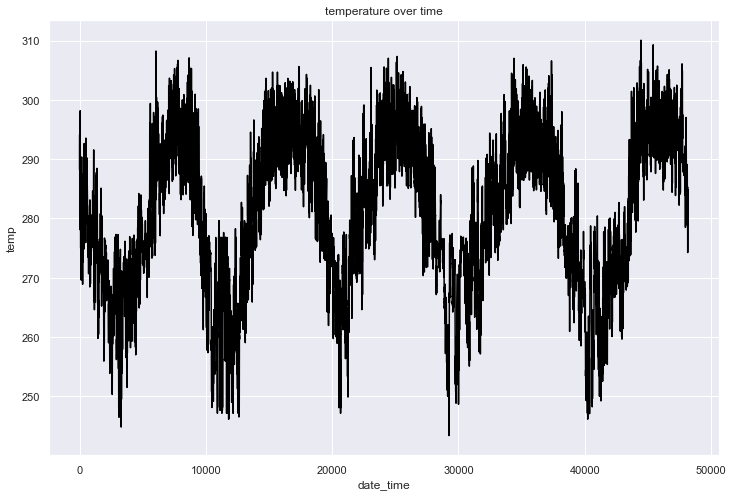

time: 219 ms (started: 2023-04-09 13:06:49 -06:00)


In [52]:
# Checking results
print(df['temp'].loc[11897:11902], df['temp'].loc[11944:11952])

# Plotting again for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

The plot looks better now that we've filled in the zero values for the temperature data. It follows the expected seasonal trend of decreasing temperatures as winter approaches and increasing temperatures as summer approaches. Next let's visually inspect the other numeric variables in the dataset: *rain_1h*, *snow_1h*, *clouds_all*, and *traffic_volume*.

Text(0.5, 1.0, 'traffic_volume')

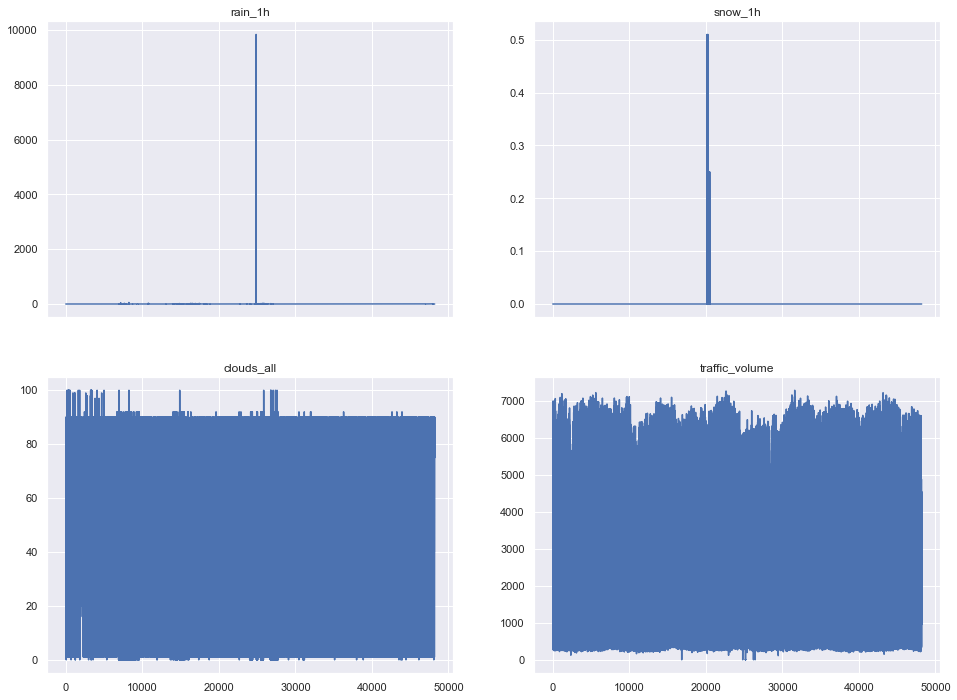

time: 719 ms (started: 2023-04-09 13:06:49 -06:00)


In [53]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df['rain_1h']); axes[0, 0].set_title('rain_1h')
axes[0, 1].plot(df['snow_1h']); axes[0, 1].set_title('snow_1h')
axes[1, 0].plot(df['clouds_all']); axes[1, 0].set_title('clouds_all')
axes[1, 1].plot(df['traffic_volume']); axes[1, 1].set_title('traffic_volume')

*clouds_all* and *traffic_volume* appear to have normal values across the dataset but there are some odd looking spikes in the data for *rain_1h* and *snow_1h*. Both of these are measured in millimeters. It's unlikely that a singular day or hour produced almost 10,000 mm of rain and the snow values are suspiciously low for a state as far North as Minnesota.

To fix this, I obtained a dataset compiled by the [National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014922/detail). The dataset provides daily weather data gathered by a weather station at the Minneapolis St. Paul International Airport and will be used to fix the issues with the UCI dataset.

In [54]:
# Top 5 hourly rainfall values
df.sort_values(by='rain_1h', ascending=False).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
25779,None,297.71,31.75,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913
10807,None,264.50,28.70,0.0,64,Snow,light snow,2013-12-19 23:00:00,1190


time: 31 ms (started: 2023-04-09 13:06:50 -06:00)


In [55]:
# Totalling snowfall values across entire dataset
df['snow_1h'].sum()

10.72

time: 0 ns (started: 2023-04-09 13:06:50 -06:00)


It's highly unlikely that 9,831 mm (approximately 32 feet!) of rain fell in one hour. It's also extremely unlikely that the total amount of snowfall listed across the entire dataset is 10.72 mm (0.42 inches). To fix this, we'll make some changes to the *date_time* column and the overall dataframe until we have a daily time series with complete and sensible values.

In [56]:
# Converting date_time column from object to datetime
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)

# Extracting various date and time values from date_time column
df['date'] = df['date_time'].dt.date
df['year'] = df['date_time'].dt.year
df['month_day'] = df['date_time'].dt.strftime('%m-%d')
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['weekday'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

# Converting newly created date column from object to datetime
df['date'] = pd.to_datetime(df['date'])

time: 422 ms (started: 2023-04-09 13:06:50 -06:00)


In [57]:
# Converting temp column to Fahrenheit values and rain/snow measurements to inches
df['temp'] = (df['temp'] - 273.15) * 9/5 + 32
df['rain_1h'] = df['rain_1h'] * 0.03937
df['snow_1h'] = df['snow_1h'] * 0.03937

# Renaming columns to show units of measurement
df = df.rename(columns={'rain_1h':'rain_in',
                        'snow_1h':'snow_in',
                        'clouds_all':'pct_cloud_cover'})

time: 15 ms (started: 2023-04-09 13:06:50 -06:00)


In [58]:
# Checking results
df.head()

,holiday,temp,rain_in,snow_in,pct_cloud_cover,weather_main,weather_description,date_time,traffic_volume,date,year,month_day,month,day,weekday,hour
0,None,59.234,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,2012,10-02,10,2,Tuesday,9
1,None,61.178,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,2012,10-02,10,2,Tuesday,10
2,None,61.574,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,2012,10-02,10,2,Tuesday,11
3,None,62.564,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,2012,10-02,10,2,Tuesday,12
4,None,64.382,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,2012,10-02,10,2,Tuesday,13


time: 16 ms (started: 2023-04-09 13:06:50 -06:00)


Our dataframe now contains values in Imperial units and we've broken the *date_time* column out into separate components. The next step is to set *date_time* as the index of our dataframe so we can resample to daily values.

In [59]:
# Setting date_time as index
df.set_index('date_time', inplace=True)

time: 0 ns (started: 2023-04-09 13:06:50 -06:00)


In [60]:
# Resampling to daily values
df_daily = df.resample('D').agg({'temp':'mean',
                                 'rain_in':'sum',
                                 'snow_in':'sum',
                                 'pct_cloud_cover':'mean',
                                 'traffic_volume':'sum',
                                 'holiday':'first',
                                 'year':'last',
                                 'month_day':'last',
                                 'month':'last',
                                 'day':'last',
                                 'weekday':'last'})

time: 31 ms (started: 2023-04-09 13:06:50 -06:00)


In [61]:
# Checking results
df_daily.head()

,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
date_time,,,,,,,,,,,
2012-10-02,63.056000,0.0,0.0,29.133333,63289,None,2012.0,10-02,10.0,2.0,Tuesday
2012-10-03,55.874300,0.0,0.0,3.850000,66345,None,2012.0,10-03,10.0,3.0,Wednesday
2012-10-04,61.173500,0.0,0.0,16.708333,89939,None,2012.0,10-04,10.0,4.0,Thursday
2012-10-05,48.070727,0.0,0.0,75.000000,93336,None,2012.0,10-05,10.0,5.0,Friday
2012-10-06,40.272957,0.0,0.0,61.652174,74910,None,2012.0,10-06,10.0,6.0,Saturday


time: 15 ms (started: 2023-04-09 13:06:50 -06:00)


We now have a dataframe with the date as our index and average values for *temp* and *pct_cloud_cover* and totals for *rain_in*, *snow_in*, and *traffic_volume*. Let's take a look at some of these graphically.

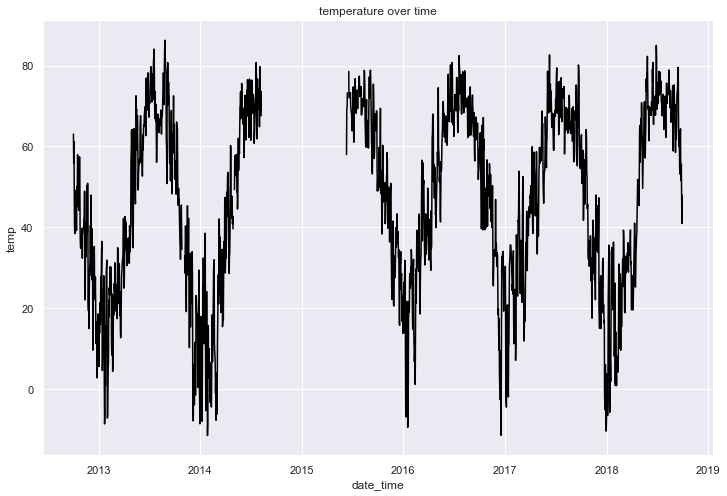

time: 234 ms (started: 2023-04-09 13:06:50 -06:00)


In [62]:
# Plotting temp for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

Text(0.5, 1.0, 'traffic_volume')

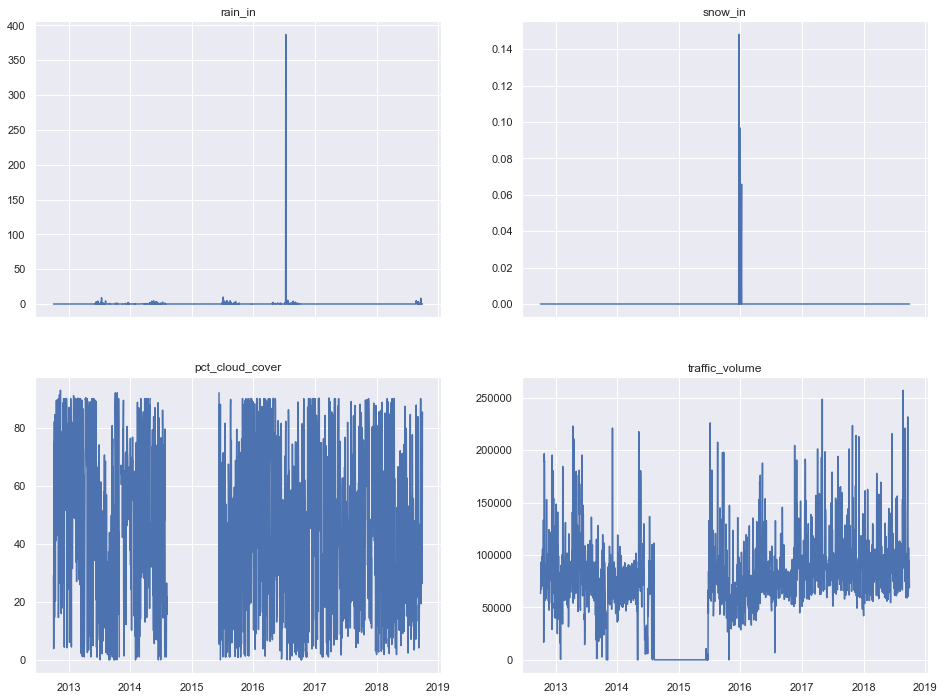

time: 766 ms (started: 2023-04-09 13:06:50 -06:00)


In [63]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df_daily['rain_in']); axes[0, 0].set_title('rain_in')
axes[0, 1].plot(df_daily['snow_in']); axes[0, 1].set_title('snow_in')
axes[1, 0].plot(df_daily['pct_cloud_cover']); axes[1, 0].set_title('pct_cloud_cover')
axes[1, 1].plot(df_daily['traffic_volume']); axes[1, 1].set_title('traffic_volume')

We still have the same oddities in the rain and snow values, but it looks like we're missing a big chunk of data from temperature, cloud cover, and traffic volume. There's also some suspiciously low traffic volume values. We know from the [MNDOT Station 301 Monthly Report](https://dot.state.mn.us/traffic/data/reports/atr/Monthly_PDFs/Oct18/301.pdf) that this stretch of I-94 averages about 160,000 vehicles every day in both directions. We know that our dataset only contains westbound traffic and although we don't know what the directional traffic split is we can assume that westbound traffic makes up a decent proportion of the roughly 160,000 daily vehicles.

To find our cutoff point, we'll loop through the 10 - 20 percent quantiles and use one of those values as our cutoff.

In [64]:
# Looping through 10-20 percent quantiles
for i in range(10, 21):
    print(str(i) + '%' + ' Quantile: %f' % df_daily['traffic_volume'].quantile(i/100))

10% Quantile: 0.000000
11% Quantile: 0.000000
12% Quantile: 0.000000
13% Quantile: 0.000000
14% Quantile: 0.000000
15% Quantile: 0.000000
16% Quantile: 8101.120000
17% Quantile: 24404.600000
18% Quantile: 32938.980000
19% Quantile: 38435.100000
20% Quantile: 41966.000000
time: 32 ms (started: 2023-04-09 13:06:51 -06:00)


The first value that appears is the 16% quantile or 8,101. Let's proceed with replacing all traffic volume values lesser than this cutoff.

In [65]:
# Checking for zero values in traffic_volume
df_daily[df_daily['traffic_volume'] < df_daily['traffic_volume'].quantile(.16)]

,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
date_time,,,,,,,,,,,
2013-01-29,30.596000,0.000000,0.0,91.00,434,None,2013.0,01-29,1.0,29.0,Tuesday
2013-08-31,78.890000,0.000000,0.0,0.00,1321,None,2013.0,08-31,8.0,31.0,Saturday
2013-09-01,61.610000,0.000000,0.0,1.00,1712,None,2013.0,09-01,9.0,1.0,Sunday
2013-09-03,50.832500,0.000000,0.0,18.75,1462,None,2013.0,09-03,9.0,3.0,Tuesday
2013-10-01,51.935000,0.000000,0.0,0.00,3969,None,2013.0,10-01,10.0,1.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-23,NaN,0.000000,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-24,NaN,0.000000,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-25,NaN,0.000000,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


time: 31 ms (started: 2023-04-09 13:06:51 -06:00)


351 days of low *traffic_volume* values, including some zeroes. That can't be right. To fix this, our best option is to find the average values from the same combinations of month and day that are present in the rest of our dataset. First, let's cast the *year*, *month*, and *day* columns as integers to get rid of those decimals.

In [66]:
df_daily['year'] = df_daily['year'].fillna(0).astype(int)
df_daily['month'] = df_daily['month'].fillna(0).astype(int)
df_daily['day'] = df_daily['day'].fillna(0).astype(int)

time: 16 ms (started: 2023-04-09 13:06:51 -06:00)


In [67]:
# Checking number of rows in df_daily
df_daily.shape

(2190, 11)

time: 0 ns (started: 2023-04-09 13:06:51 -06:00)


In [68]:
# Creating new dataframe with no low values and checking new number of rows
df_daily_avg = df_daily[df_daily['traffic_volume'] > df_daily['traffic_volume'].quantile(.16)]
df_daily_avg.shape

(1839, 11)

time: 0 ns (started: 2023-04-09 13:06:51 -06:00)


2190 - 1839 = 351, that checks out. Next we'll group by month and day to find the average *traffic_volume* and *pct_cloud_cover* values for each of our non-cutoff values.

In [69]:
# Group by month and day, calculate the mean, reset index, and check results
df_daily_avg = df_daily_avg.groupby(['month_day']).agg({'traffic_volume':'mean',
                                                        'pct_cloud_cover':'mean'})
df_daily_avg = df_daily_avg.reset_index()
df_daily_avg['traffic_volume'] = df_daily_avg['traffic_volume'].astype('int')
df_daily_avg['pct_cloud_cover'] = df_daily_avg['pct_cloud_cover'].astype('int')

df_daily_avg

,month_day,traffic_volume,pct_cloud_cover
0,01-01,40675,36
1,01-02,79661,47
2,01-03,92301,60
3,01-04,82860,41
4,01-05,66190,27
...,...,...,...
361,12-27,68401,44
362,12-28,90395,62
363,12-29,78483,67
364,12-30,68243,51


time: 16 ms (started: 2023-04-09 13:06:51 -06:00)


Once again we'll reset the index of our <b>df_daily</b> dataframe and extract the month and day values so we can merge it with our <b>df_daily_avg</b> dataframe.

In [70]:
# Making new dataframe with low values for traffic_volume
df_fix = df_daily[df_daily['traffic_volume'] < df_daily['traffic_volume'].quantile(.16)]

# Resetting index and creating month_day column
df_fix = df_fix.reset_index()
df_fix['month_day'] = df_fix['date_time'].dt.strftime('%m-%d')

# Checking results
df_fix

,date_time,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
0,2013-01-29,30.596000,0.000000,0.0,91.00,434,None,2013,01-29,1,29,Tuesday
1,2013-08-31,78.890000,0.000000,0.0,0.00,1321,None,2013,08-31,8,31,Saturday
2,2013-09-01,61.610000,0.000000,0.0,1.00,1712,None,2013,09-01,9,1,Sunday
3,2013-09-03,50.832500,0.000000,0.0,18.75,1462,None,2013,09-03,9,3,Tuesday
4,2013-10-01,51.935000,0.000000,0.0,0.00,3969,None,2013,10-01,10,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
346,2015-06-23,NaN,0.000000,0.0,NaN,0,NaN,0,06-23,0,0,NaN
347,2015-10-24,NaN,0.000000,0.0,NaN,0,NaN,0,10-24,0,0,NaN
348,2015-10-25,NaN,0.000000,0.0,NaN,0,NaN,0,10-25,0,0,NaN
349,2015-10-26,NaN,0.000000,0.0,NaN,0,NaN,0,10-26,0,0,NaN


time: 31 ms (started: 2023-04-09 13:06:51 -06:00)


In [71]:
# Merging dataframes and checking results
merge = pd.merge(df_fix, df_daily_avg, on ='month_day', how='inner')
merge

,date_time,temp,rain_in,snow_in,pct_cloud_cover_x,traffic_volume_x,holiday,year,month_day,month,day,weekday,traffic_volume_y,pct_cloud_cover_y
0,2013-01-29,30.596000,0.000000,0.0,91.0,434,None,2013,01-29,1,29,Tuesday,76910,39
1,2015-01-29,NaN,0.000000,0.0,NaN,0,NaN,0,01-29,0,0,NaN,76910,39
2,2013-08-31,78.890000,0.000000,0.0,0.0,1321,None,2013,08-31,8,31,Saturday,99506,24
3,2014-08-31,NaN,0.000000,0.0,NaN,0,NaN,0,08-31,0,0,NaN,99506,24
4,2013-09-01,61.610000,0.000000,0.0,1.0,1712,None,2013,09-01,9,1,Sunday,79378,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2015-06-19,78.542600,0.000000,0.0,0.0,4681,None,2015,06-19,6,19,Friday,88133,52
347,2015-06-20,71.994200,0.000000,0.0,88.0,4045,None,2015,06-20,6,20,Saturday,70593,29
348,2015-06-21,NaN,0.000000,0.0,NaN,0,NaN,0,06-21,0,0,NaN,61849,22
349,2015-06-23,NaN,0.000000,0.0,NaN,0,NaN,0,06-23,0,0,NaN,68452,34


time: 32 ms (started: 2023-04-09 13:06:51 -06:00)


We've successsfully added the average *traffic_volume* and *pct_cloud_cover* values for our values beneath the cutoff, now we'll drop all the unnecessary columns so it's easier to perform another merge with our <b>df_daily</b> dataframe.

In [72]:
# Keeping just the relevant columns
merge = merge[['date_time', 'traffic_volume_y', 'pct_cloud_cover_y']]
merge

,date_time,traffic_volume_y,pct_cloud_cover_y
0,2013-01-29,76910,39
1,2015-01-29,76910,39
2,2013-08-31,99506,24
3,2014-08-31,99506,24
4,2013-09-01,79378,25
...,...,...,...
346,2015-06-19,88133,52
347,2015-06-20,70593,29
348,2015-06-21,61849,22
349,2015-06-23,68452,34


time: 16 ms (started: 2023-04-09 13:06:51 -06:00)


In [73]:
# Resetting df_daily index for merge and performing merge
df_daily.reset_index(inplace=True)
df_daily = pd.merge(df_daily, merge, on ='date_time', how='left')

# Checking results
df_daily

,date_time,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday,traffic_volume_y,pct_cloud_cover_y
0,2012-10-02,63.056000,0.000000,0.0,29.133333,63289,None,2012,10-02,10,2,Tuesday,NaN,NaN
1,2012-10-03,55.874300,0.000000,0.0,3.850000,66345,None,2012,10-03,10,3,Wednesday,NaN,NaN
2,2012-10-04,61.173500,0.000000,0.0,16.708333,89939,None,2012,10-04,10,4,Thursday,NaN,NaN
3,2012-10-05,48.070727,0.000000,0.0,75.000000,93336,None,2012,10-05,10,5,Friday,NaN,NaN
4,2012-10-06,40.272957,0.000000,0.0,61.652174,74910,None,2012,10-06,10,6,Saturday,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2018-09-26,51.522500,0.009843,0.0,39.833333,88627,None,2018,09-26,9,26,Wednesday,NaN,NaN
2186,2018-09-27,55.613120,0.019685,0.0,61.200000,94434,None,2018,09-27,9,27,Thursday,NaN,NaN
2187,2018-09-28,47.189000,0.000000,0.0,26.250000,92518,None,2018,09-28,9,28,Friday,NaN,NaN
2188,2018-09-29,40.973360,0.009843,0.0,57.360000,76242,None,2018,09-29,9,29,Saturday,NaN,NaN


time: 46 ms (started: 2023-04-09 13:06:51 -06:00)


In [74]:
# Replacing low traffic volumes with their daily averages
df_daily.loc[df_daily['traffic_volume'] < df_daily['traffic_volume'].quantile(.16),
             'traffic_volume'] = df_daily['traffic_volume_y']

# Replacing null cloud cover values with their daily averages
df_daily.loc[df_daily['pct_cloud_cover'].isnull(), 'pct_cloud_cover'] = df_daily['pct_cloud_cover_y']

time: 16 ms (started: 2023-04-09 13:06:52 -06:00)


In [75]:
# Dropping unnecessary columns
df_daily.drop(['traffic_volume_y', 'pct_cloud_cover_y'], axis=1, inplace=True)

time: 0 ns (started: 2023-04-09 13:06:52 -06:00)


In [76]:
# Checking statistical values for our modified columns
df_daily[['pct_cloud_cover', 'traffic_volume']].describe()

,pct_cloud_cover,traffic_volume
count,2190.000000,2190.000000
mean,45.742471,85492.527397
std,26.538566,29113.950551
min,0.000000,10676.000000
25%,23.218750,68671.750000
50%,46.000000,84564.500000
75%,66.394828,94134.750000
max,92.880000,257191.000000


time: 15 ms (started: 2023-04-09 13:06:52 -06:00)


The mean values for the two columns we've modified are reasonable. Remember earlier when we saw approximately 32 feet of rainfall in one hour and the total amount of snowfall listed across the entire dataset as 0.42 inches? In addition we saw that there is a big chunk of temperature data missing. Let's look at the NOAA dataset and see how we can use that to complete our dataset.

In [77]:
# Viewing column data for NOAA dataset
df_noaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    2190 non-null   object 
 1   NAME       2190 non-null   object 
 2   LATITUDE   2190 non-null   float64
 3   LONGITUDE  2190 non-null   float64
 4   ELEVATION  2190 non-null   float64
 5   DATE       2190 non-null   object 
 6   AWND       2190 non-null   float64
 7   PGTM       2 non-null      float64
 8   PRCP       2190 non-null   float64
 9   SNOW       2190 non-null   float64
 10  SNWD       2190 non-null   float64
 11  TAVG       2009 non-null   float64
 12  TMAX       2190 non-null   int64  
 13  TMIN       2190 non-null   int64  
 14  WDF2       2190 non-null   int64  
 15  WDF5       2189 non-null   float64
 16  WSF2       2190 non-null   float64
 17  WSF5       2189 non-null   float64
 18  WT01       760 non-null    float64
 19  WT02       35 non-null     float64
 20  WT03    

In [78]:
# Making new dataframe with just the relevant columns
df_noaa_fix = df_noaa[['DATE', 'PRCP', 'SNOW', 'TAVG']]
df_noaa_fix

,DATE,PRCP,SNOW,TAVG
0,2012-10-02,0.0,0.0,NaN
1,2012-10-03,0.0,0.0,NaN
2,2012-10-04,0.0,0.0,NaN
3,2012-10-05,0.0,0.0,NaN
4,2012-10-06,0.0,0.0,NaN
...,...,...,...,...
2185,2018-09-26,0.0,0.0,52.0
2186,2018-09-27,0.0,0.0,58.0
2187,2018-09-28,0.0,0.0,50.0
2188,2018-09-29,0.0,0.0,43.0


time: 16 ms (started: 2023-04-09 13:06:52 -06:00)


In [79]:
# Converting to datetime value
df_noaa_fix['DATE'] = pd.to_datetime(df_noaa_fix['DATE'], infer_datetime_format=True)

# Renaming column to match df_daily
df_noaa_fix.rename(columns={'DATE':'date_time'}, inplace=True)

# Checking results
df_noaa_fix

<ipython-input-79-ad83066ce833>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noaa_fix['DATE'] = pd.to_datetime(df_noaa_fix['DATE'], infer_datetime_format=True)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,date_time,PRCP,SNOW,TAVG
0,2012-10-02,0.0,0.0,NaN
1,2012-10-03,0.0,0.0,NaN
2,2012-10-04,0.0,0.0,NaN
3,2012-10-05,0.0,0.0,NaN
4,2012-10-06,0.0,0.0,NaN
...,...,...,...,...
2185,2018-09-26,0.0,0.0,52.0
2186,2018-09-27,0.0,0.0,58.0
2187,2018-09-28,0.0,0.0,50.0
2188,2018-09-29,0.0,0.0,43.0


time: 32 ms (started: 2023-04-09 13:06:52 -06:00)


Excellent - we now have a dataframe with a matching *date_time* column and rain, snow, and temperature values that can be used to fill in the gaps in <b>df_daily</b>.

In [80]:
# Merging dataframes
df_daily = pd.merge(df_daily, df_noaa_fix, on ='date_time', how='left')
df_daily

,date_time,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday,PRCP,SNOW,TAVG
0,2012-10-02,63.056000,0.000000,0.0,29.133333,63289.0,None,2012,10-02,10,2,Tuesday,0.0,0.0,NaN
1,2012-10-03,55.874300,0.000000,0.0,3.850000,66345.0,None,2012,10-03,10,3,Wednesday,0.0,0.0,NaN
2,2012-10-04,61.173500,0.000000,0.0,16.708333,89939.0,None,2012,10-04,10,4,Thursday,0.0,0.0,NaN
3,2012-10-05,48.070727,0.000000,0.0,75.000000,93336.0,None,2012,10-05,10,5,Friday,0.0,0.0,NaN
4,2012-10-06,40.272957,0.000000,0.0,61.652174,74910.0,None,2012,10-06,10,6,Saturday,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2018-09-26,51.522500,0.009843,0.0,39.833333,88627.0,None,2018,09-26,9,26,Wednesday,0.0,0.0,52.0
2186,2018-09-27,55.613120,0.019685,0.0,61.200000,94434.0,None,2018,09-27,9,27,Thursday,0.0,0.0,58.0
2187,2018-09-28,47.189000,0.000000,0.0,26.250000,92518.0,None,2018,09-28,9,28,Friday,0.0,0.0,50.0
2188,2018-09-29,40.973360,0.009843,0.0,57.360000,76242.0,None,2018,09-29,9,29,Saturday,0.0,0.0,43.0


time: 31 ms (started: 2023-04-09 13:06:52 -06:00)


In [81]:
# Replacing null temperature values with values from NOAA
df_daily.loc[df_daily['temp'].isnull(), 'temp'] = df_daily['TAVG']

# Replacing all rainfall and snowfall values with values from NOAA
df_daily['snow_in'] = df_daily['SNOW']
df_daily['rain_in'] = df_daily['PRCP']

time: 15 ms (started: 2023-04-09 13:06:52 -06:00)


In [82]:
# Viewing row with rainfall outlier
# df_daily[df_daily['date_time'] == '2016-07-11']

time: 0 ns (started: 2023-04-09 13:06:52 -06:00)


In [83]:
# Replacing rainfall outlier with NOAA value and checking result
# df_daily.loc[df_daily['rain_in'] > 387, 'rain_in'] = df_daily['PRCP']
# df_daily[df_daily['date_time'] == '2016-07-11']

time: 0 ns (started: 2023-04-09 13:06:52 -06:00)


In [84]:
# Dropping unnecessary columns
df_daily.drop(['PRCP', 'SNOW', 'TAVG'], axis=1, inplace=True)

# Checking results
df_daily.head()

,date_time,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume,holiday,year,month_day,month,day,weekday
0,2012-10-02,63.056000,0.0,0.0,29.133333,63289.0,None,2012,10-02,10,2,Tuesday
1,2012-10-03,55.874300,0.0,0.0,3.850000,66345.0,None,2012,10-03,10,3,Wednesday
2,2012-10-04,61.173500,0.0,0.0,16.708333,89939.0,None,2012,10-04,10,4,Thursday
3,2012-10-05,48.070727,0.0,0.0,75.000000,93336.0,None,2012,10-05,10,5,Friday
4,2012-10-06,40.272957,0.0,0.0,61.652174,74910.0,None,2012,10-06,10,6,Saturday


time: 32 ms (started: 2023-04-09 13:06:52 -06:00)


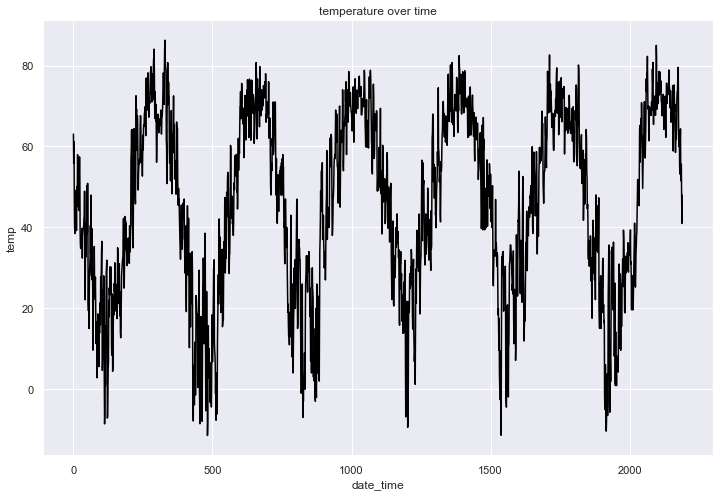

time: 172 ms (started: 2023-04-09 13:06:52 -06:00)


In [85]:
# Plotting temp for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

Text(0.5, 1.0, 'traffic_volume')

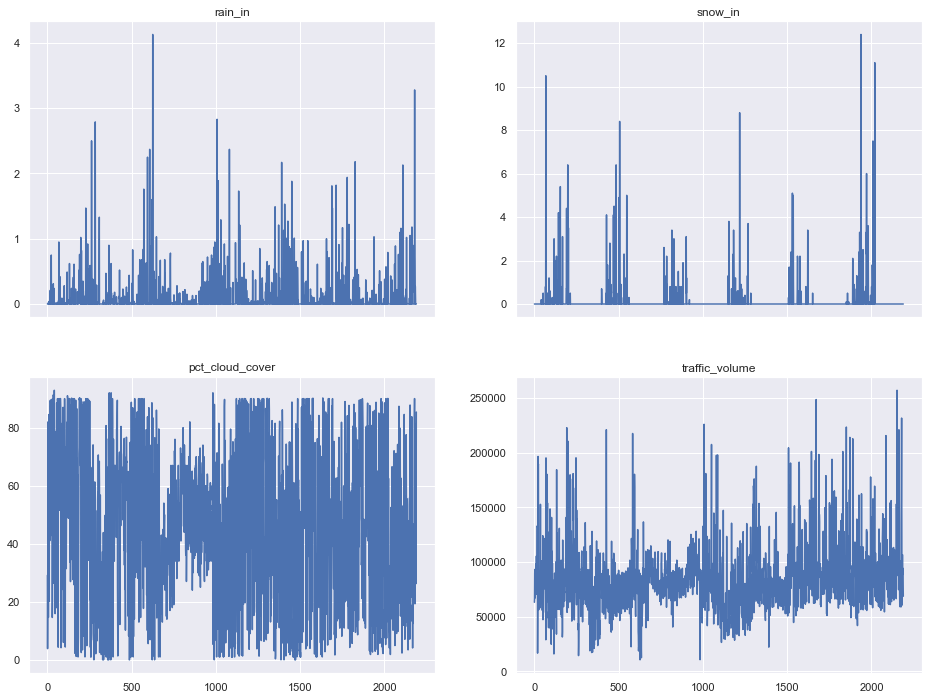

time: 500 ms (started: 2023-04-09 13:06:52 -06:00)


In [86]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df_daily['rain_in']); axes[0, 0].set_title('rain_in')
axes[0, 1].plot(df_daily['snow_in']); axes[0, 1].set_title('snow_in')
axes[1, 0].plot(df_daily['pct_cloud_cover']); axes[1, 0].set_title('pct_cloud_cover')
axes[1, 1].plot(df_daily['traffic_volume']); axes[1, 1].set_title('traffic_volume')

In [95]:
# Calculating average daily temperature  and average yearly rain/snow values
print(df_daily['temp'].sum() / (len(df_daily.index)))
print(df_daily['rain_in'].sum() / (len(df_daily.index) / 365))
print(df_daily['snow_in'].sum() / (len(df_daily.index) / 365))

45.90382363831284
34.625
52.81666666666666
time: 0 ns (started: 2023-04-09 13:09:41 -06:00)


We've done it! At last we have a dataset with complete, sensible daily values. We can finally begin modelling.

In [96]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_time        2190 non-null   datetime64[ns]
 1   temp             2190 non-null   float64       
 2   rain_in          2190 non-null   float64       
 3   snow_in          2190 non-null   float64       
 4   pct_cloud_cover  2190 non-null   float64       
 5   traffic_volume   2190 non-null   float64       
 6   holiday          1860 non-null   object        
 7   year             2190 non-null   int32         
 8   month_day        1860 non-null   object        
 9   month            2190 non-null   int32         
 10  day              2190 non-null   int32         
 11  weekday          1860 non-null   object        
dtypes: datetime64[ns](1), float64(5), int32(3), object(3)
memory usage: 276.8+ KB
time: 0 ns (started: 2023-04-09 13:09:58 -06:00)


In [97]:
df_daily.drop(['year', 'month', 'day'], axis=1).corr()

,temp,rain_in,snow_in,pct_cloud_cover,traffic_volume
temp,1.000000,0.161010,-0.194483,-0.220893,0.109114
rain_in,0.161010,1.000000,0.171955,0.239767,0.235239
snow_in,-0.194483,0.171955,1.000000,0.193427,0.008450
pct_cloud_cover,-0.220893,0.239767,0.193427,1.000000,0.334970
traffic_volume,0.109114,0.235239,0.008450,0.334970,1.000000


time: 16 ms (started: 2023-04-09 13:09:58 -06:00)


# Baseline Model

To start, we'll make a baseline model with just the dates and traffic volume values.

In [109]:
df_daily.set_index('date_time', inplace=True)

df_baseline = df_daily['traffic_volume']
df_baseline

date_time
2012-10-02    63289.0
2012-10-03    66345.0
2012-10-04    89939.0
2012-10-05    93336.0
2012-10-06    74910.0
               ...   
2018-09-26    88627.0
2018-09-27    94434.0
2018-09-28    92518.0
2018-09-29    76242.0
2018-09-30    68785.0
Name: traffic_volume, Length: 2190, dtype: float64

time: 0 ns (started: 2023-04-09 13:15:55 -06:00)


In [99]:
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error

# Create lagged dataset
values = DataFrame(df_baseline.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

       t-1      t+1
0      NaN  63289.0
1  63289.0  66345.0
2  66345.0  89939.0
3  89939.0  93336.0
4  93336.0  74910.0
time: 15 ms (started: 2023-04-09 13:09:58 -06:00)


In [100]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.8)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

time: 0 ns (started: 2023-04-09 13:09:58 -06:00)


In [136]:
train

date_time
2012-10-02     63289.0
2012-10-03     66345.0
2012-10-04     89939.0
2012-10-05     93336.0
2012-10-06     74910.0
                ...   
2017-07-15     67582.0
2017-07-16     64138.0
2017-07-17     90116.0
2017-07-18    106965.0
2017-07-19    154315.0
Name: traffic_volume, Length: 1752, dtype: float64

time: 0 ns (started: 2023-04-09 13:46:13 -06:00)


In [101]:
# persistence model
def model_persistence(x):
 return x

time: 0 ns (started: 2023-04-09 13:09:58 -06:00)


In [102]:
# walk-forward validation
predictions = list()
for x in test_X:
 yhat = model_persistence(x)
 predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
print('Test RMSE: %.3f' % np.sqrt(test_score))

Test MSE: 1385776125.539
Test RMSE: 37226.014
time: 0 ns (started: 2023-04-09 13:09:58 -06:00)


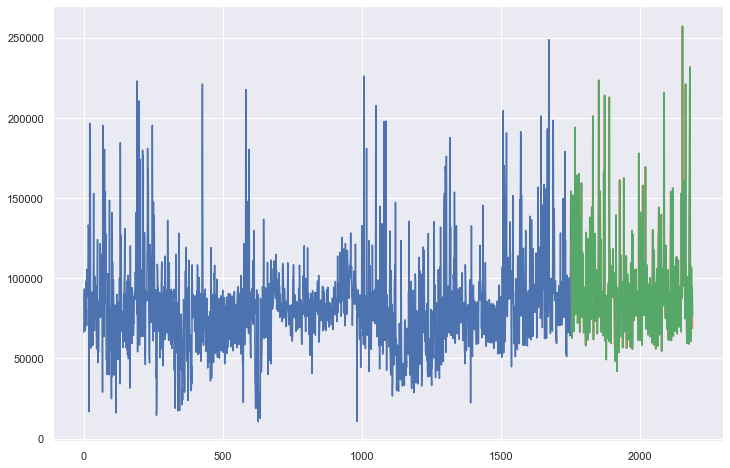

time: 203 ms (started: 2023-04-09 13:09:58 -06:00)


In [103]:
# plot predictions and expected results
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

# First Simple Model

In [115]:
# Define train and test sets
train_size = int(len(df_baseline) * 0.8)

train = df_baseline[:train_size]
test = df_baseline[train_size:]

time: 0 ns (started: 2023-04-09 13:21:52 -06:00)


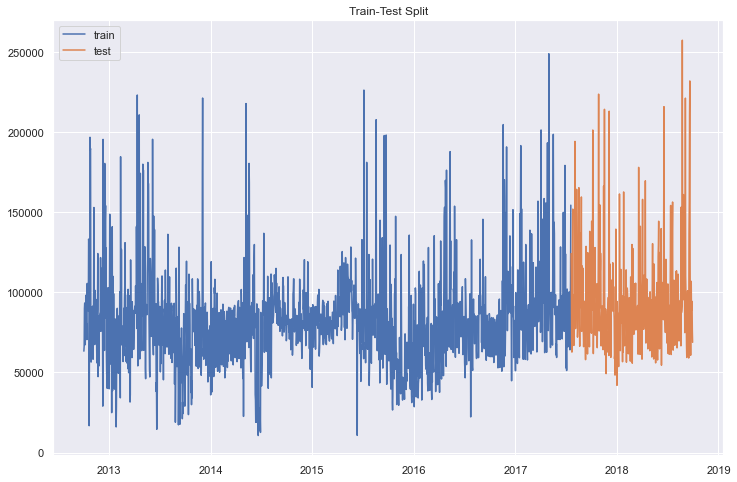

time: 265 ms (started: 2023-04-09 13:22:36 -06:00)


In [118]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [131]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

ad_test = adfuller(df_baseline)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {ad_test},")
if ad_test < 0.05:
    print(" therefore we can safely assume that the dataset is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the dataset is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.4989446630712853e-06,
 therefore we can safely assume that the dataset is stationary.
time: 78 ms (started: 2023-04-09 13:40:26 -06:00)


In [132]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train, order=(1, 0, 2)).fit()

# Predictions from model
y_pred = model.predict(start = test.index[0], end = test.index[-1])

C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


time: 453 ms (started: 2023-04-09 13:40:31 -06:00)


In [133]:
# MSE and RMSE scores
test_score = mean_squared_error(test, y_pred)
print('Test MSE: %.3f' % test_score)
print('Test RMSE: %.3f' % np.sqrt(test_score))

Test MSE: 1017403971.023
Test RMSE: 31896.771
time: 0 ns (started: 2023-04-09 13:40:34 -06:00)


In [124]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Call the function and run the test
adf_test(df_baseline)

Results of Dickey-Fuller Test:
Test Statistic                   -5.566721
p-value                           0.000001
#Lags Used                       22.000000
Number of Observations Used    2167.000000
Critical Value (1%)              -3.433371
Critical Value (5%)              -2.862875
Critical Value (10%)             -2.567481
dtype: float64
time: 94 ms (started: 2023-04-09 13:29:17 -06:00)


In [125]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(df_baseline)

Results of KPSS Test:
Test Statistic            1.85936
p-value                   0.01000
#Lags Used               19.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
time: 15 ms (started: 2023-04-09 13:30:43 -06:00)


C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
